# Automatic delineation of field boundaries on satellite images

```
TODO: Add intro
```

In [1]:
# Mount google drive folder
# from google.colab import drive
# drive.mount('/content/drive/')


In [2]:
import os
import numpy as np
import typing
import keras
import tensorflow as tf
from skimage import exposure
from osgeo import gdal

# Install keras-unet library for python
%pip install git+https://github.com/karolzak/keras-unet


# # define dataset directory
# from google.colab import drive

BASE_PATH = "/home/jovyan/private/Agricultural_Field_Boundary"
INPUT_PATH = BASE_PATH + "/original/"
OUTPUT_PATH = BASE_PATH + "/Networks"
IMAGE_PATH = "/Original"
LABEL_PATH = "/Classified"

# INCLUDE_FOLDERS = ["Flevoland", "Friesland", "Gelderland", "Limburg", "Overijssel", "Zeeland", "Zuid-Holland", "Vietnam", "Cambodia"]
INCLUDE_FOLDERS = ["Vietnam"]
LEGEND = {
    1: 'Other',
    2: 'Field Boundary'
}


# To assess the accuracy you have to define the networks UUID and name here
NETWORK_UUID = "6c0f7e24-a85a-11ec-938c-02420a0001f1"

# Allowed Values:
#   * FCNDK3
#   * FCNDK4
#   * FCNDK5
#   * FCNDK6
#   * UNet2
#   * UNet3
#   * UNet5
NETWORK_NAME = "UNet5"


# To compile the model, also the optimizer has to be defined
NETWORK_OPTIMIZER = "Adam"

# Ensure you use the same optimizer parameters as in the training run
SGD_LEARNING_RATE = 0.0015
SGD_MOMENTUM = 0.9
ADAM_LEARNING_RATE = 0.0015
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON = 1e-06


# Remark: All information in here could have been loaded from the training
#         configuration file as well. However, we missed the chance to export
#         the configuration as a machine readable type, e.g. JSON.
#         Thus, we did not pass the config from the readme manually but set the
#         parameters manually in here.



Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-89nvfhq0
  Running command git clone --filter=blob:none --quiet https://github.com/karolzak/keras-unet /tmp/pip-req-build-89nvfhq0
  Resolved https://github.com/karolzak/keras-unet to commit 9b7aff5247fff75dc4e2a11ba9c45929b9166d1f
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# ################################################################
# Prerequisites for the network
#
# Includes a few helper functions which will be used to create and
# evaluate the network, the training and the accuracy.
# ################################################################

import imp, h5py
import dill, pickle
import uuid
imp.reload(h5py)
from tensorflow.python.keras import backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session


# Tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))



# Helper functions for the networks
# ################################################################
# Helper functions - import/export of network
#
# These two functions help to export the network and import it.
# That allows to skip the training at a later stage.
# ################################################################

class ModelHistory:
    """Just a small container class to hold relevant information of a trained
    model.
    """

    def __init__(self, uuid, name, model, history, readme):
        """Create a new instance of this class
        :param uuid: A unique identifier of the network
        :param name: The networks name
        :param model: The pretrained model
        :param history: The training history of the model
        :param readme: A small readme with a summary of training parameters
        """
        self.uuid = uuid
        self.name = name
        self.model = model
        self.history = history
        self.readme = readme


def get_file_names(uuid, name):
    """Generates three file names for the model, weights and history file and
    the networks readme.

    File name order of returned tuple:
        * readme
        * model
        * weights
        * history

    :param uuid: Universal unique identifier of a trained network
    :param name: The networks name
    :return: Tuple with files in the order mentioned above
    """
    base = f"{OUTPUT_PATH}/{str(uuid)}-{name}"

    f_readme = f"{base}-readme.txt"
    f_model = f"{base}-model.h5"
    f_weights = f"{base}-weights.h5"
    f_history = f"{base}-history"

    return (f_readme, f_model, f_weights, f_history)


def export_model(m: ModelHistory):
    """If a model is sufficiently trained, it can be exported. This allows to
    simply save the models state and the training history. Whenever one want to
    use the model the next time, the training can be skipped, since the trained
    model can just be imported from files.

    :param model_history: The trained model and history to be stored
    """
    f_readme, f_model, f_weights, f_history = get_file_names(m.uuid,m.name)

    # save readme
    with open(f_readme, 'w') as f:
        f.write(m.readme)
    print(f"Exported README: {f_readme}")

    # save models & weights
    m.model.save(f_model)
    print(f"Exported model: {f_model}")
    m.model.save_weights(f_weights)
    print(f"Exported weights: {f_weights}")

    # save history
    with open(f_history, "wb") as f:
        pickle.dump(m.history, f)
    print(f"Exported history: {f_history}")

def import_model(uuid, name):
    """Previously exported models can be imported with this funciton.
    :param uuid: The networks uuid
    :param name: The networks name
    :return: Instance of ModelHistory
    """
    f_readme, f_model, f_weights, f_history = get_file_names(uuid, name)

    # Load readme
    with open(f_readme, 'r') as f:
        readme = "".join(f.readlines())
    print(f"Imported README: {f_readme}")

    # Load model & weights
    # model = tf.keras.models.load_model(f_model)
    # Load model & weights, setting compile to 'False' when applying customer
    # defined loss functions
    model = tf.keras.models.load_model(f_model, compile=False)
    print(f"Imported model: {f_model}")
    model.load_weights(f_weights)
    print(f"Imported weights: {f_weights}")

    # Load history
    with open(f_history, 'rb') as f:
        history = pickle.load(f)
    print(f"Imported history: {f_history}")

    return ModelHistory(uuid, name, model, history, readme)


2022-08-11 12:46:40.715178: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [4]:
# ################################################################
# Loading test data based on README
#
# Previously, we trained the network with plenty of different
# hyper parameters. Also, we validated the training to find
# optimal parameters. Unfortunately, the training configuration
# was just stored as a text document. Thus, we read the test keys
# and only load those files which will be used for the accuraccy
# assessment.
# ################################################################

# model_history = import_model(NETWORK_UUID, NETWORK_NAME)

# readme = model_history.readme

# # Just consider the test set information
# test_set = readme.split("Test Set:")[1]
# test_set = test_set.split('\n')

# test_key_set = []

# for entry in test_set:
#     entry = entry.strip()
#     if not entry:
#         # Skip empty lines
#         continue

#     # remove non-required characters
#     entry = entry.replace("(", "")
#     entry = entry.replace(")", "")
#     entry = entry.replace(",", "")

#     province, index = tuple(entry.split())

#     test_key_set.append((province, int(index)))

#     print(f"Added key to test set: ({province}, {index})")

# ################################################################
# Loading test data manually
# ################################################################
province = 'vietnam'
index = 20
test_key_set = []
test_key_set.append((province, int(index)))
print(f"Added key to test set: ({province}, {index})")

Added key to test set: (vietnam, 20)


In [5]:
# ################################################################
# Loading input data
#
# Input data is loaded into two dictionaries: 
#
# images: contains the 4-band images. The values are loaded as ints.
# labels: contains 3D arrays in which each pixel is assigned with 
#         a label "1" = other and "2" = field boundary
#
# ################################################################


def key_generator(file_name):
    """Generates the key of a file based on the file name. The resulting key is
    a tuple of the province as string & the file number index as int,
    e.g. ("gelderland", 29)
    """
    file_name = file_name.lower()
    file_name = file_name.replace("classified_", "")
    file_name = file_name.replace("original_", "")
    file_name = file_name.replace(".tif", "")
    # TODO: Some images are named incorrectly
    #       (e.g. no '_' between the province name and the image index)
    (province, index) = tuple(file_name.split("_"))
    index = int(index)
    return (province, index)

def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)

def transform_classification_image(input):
    """Takes the classification image input (in RGB format as 3D array) and
    creates a 2D array out of this. The innermost array expects either values of
    [0, 0, 0] of [255, 255, 255] since this is the colouring we assigned to the
    classified images.

    :param input: 3D input image (classification)
    :return: 2D array image with labels 1 for 'other' and 2 for 'field_boundaries'
    """

    # Out of the 3D input array it takes the "max" element out of the array
    # This will either be 0 or 255. This function is just called to transform
    # the 3D array to a 2D array.
    result = np.reshape(np.max(input, axis=2), (input.shape[0], input.shape[1], 1))

    # Now the array consists of pixels with values "0" or "255". We transform
    # each value, that is larger than 0 (i.e. 255) and assign the label "2" to
    # it. Each other element (i.e. 0) will get assigned the label "1".
    result = np.where(result > 0, 2, 1)
    return result

# Dictionaries which contain the input data
x_dict = {}
y_dict = {}

# Iterate through defined folders and load all image data into the dictionaries
# image_data and label_data. Images can be accessed with (<province>, <index>)
for folder in INCLUDE_FOLDERS:
    original = INPUT_PATH + folder + IMAGE_PATH
    classified = INPUT_PATH + folder + LABEL_PATH

    for f in os.listdir(original): 
        value = gtiff_to_array(original + "/" + f)
        key = key_generator(f)
        if key in test_key_set:
            x_dict[key] = gtiff_to_array(original + "/" + f)


    for f in os.listdir(classified):
        key = key_generator(f)
        if key in test_key_set:
            value = gtiff_to_array(classified + "/" + f) 
            # Transform the classification image from RGB to labels "1" and "2"
            value = transform_classification_image(value)
            y_dict[key] = value


# Assert as many images & labels exist as keys
assert len(test_key_set) == len(x_dict)
assert len(test_key_set) == len(y_dict)

print(f"Shape of sample image file: {list(x_dict.values())[0].shape}")
print(f"Shape of sample label file: {list(y_dict.values())[0].shape}")

print(f"Total number of image & label tiles: {len(x_dict)}")

Shape of sample image file: (768, 768, 4)
Shape of sample label file: (768, 768, 1)
Total number of image & label tiles: 1


In [6]:
# ################################################################
# Normalizing images
#
# Normalizing all input images into values in the interval [0, 1].
# All bands are normalized seperately, which means, the min & max
# of each band is calculated based on each band of the image data.
# ################################################################

def normalize_array_1(arr):
    """Takes a 3D array as input, iterates over the bands and normalizes those
    within one image.

    :param arr: input array (original image data)
    :return: normalized data with values between 0 and 1
    """
    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        min = arr[:, :, i].min()
        max = arr[:, :, i].max()
        arr_norm[:, :, i] = (arr[:, :, i] - min) / (max - min)
    return arr_norm


def normalize_array_2(arr, minimum, maximum):
    """Takes a 3D array as input, iterates over the bands and normalizes those
    over a set of images.

    :param arr: input array (original image data)
    :param minimum & maximum: minimum and maximum values over a set of images
     for each band
    :return: normalized data with values between 0 and 1
    """
    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        arr_norm[:,:,i] = (arr[:,:,i] - minimum[i]) / (maximum[i] - minimum[i])
    return arr_norm


def normalize_array_min_max(arr, minimum, maximum):
    """Takes a 3D array as input, iterates over the bands and normalizes those
    over a set of images.

    :param arr: input array (original image data)
    :param minimum & maximum: minimum and maximum values over a set of images
     for each band
    :return: normalized data with values between minimum and maximum
    """
    arr_norm = np.zeros(arr.shape, dtype=np.float32)

    for i in range(arr.shape[2]):
        min = arr[:, :, i].min()
        max = arr[:, :, i].max()
        arr_norm[:, :, i] = (arr[:, :, i] - min) * ((maximum[i] - minimum[i])/(max - min)) + minimum[i]
    return arr_norm

# minimum and maximum for 5m buffer dataset (WGS1984)
# minimum = [302, 587, 392, 920]
# maximum = [2500, 3264, 4000, 5900]
# minimum and maximum for 7m buffer dataset (Mercator_Auxiliary_Sphere)
# minimum = [314, 587, 390, 913]
# maximum = [2500, 3264, 4000, 5857]
# minimum and maximum for 7m buffer single day image (Mercator_Auxiliary_Sphere)
# minimum = [160, 332, 323, 367]
# maximum = [3163, 4190, 5234, 4918]
## Normalization for Sentinel-2 anuual image tiles
minimum = [267, 377, 265, 298]
maximum = [5740, 5908, 6100, 6220]
for k, v in x_dict.items():
    x_dict[k] = normalize_array_2(v, minimum, maximum)
    print(f"Performed normalization of {k[0]}_{k[1]}")


Performed normalization of vietnam_20


# Setting up the network



In [7]:
# ################################################################
# Network builder functions
#
# Dynamic builder function for the FCN-DK (supposted from layer 2 to 6)
# and unet (layer 1 to 5).
# ################################################################
from keras.layers import Activation, BatchNormalization, Convolution2D, LeakyReLU, Reshape, ZeroPadding2D
from keras.models import Sequential
# TODO: Consider which optimizer is the best
from tensorflow.keras.optimizers import SGD, Adam
from keras_unet.models import satellite_unet

def build_unet(
    x: int,
    y: int,
    bands: int,
    labels: int,
    layers: int = 2,
) -> tf.keras.Model:
    """Create  a model of the popular U-Net network.

    :param x: Number of rows (x-shape)
    :param y: Number of columns (y-shape)
    :param bands: Number of bands (z-shape)
    :param lables: Number of labels to predict with the network
    :param layers: Number of layers of the network
    :return: Model of the corresponding U-Net network
    """
    model = satellite_unet(
        input_shape=(x, y, bands),
        num_classes=labels,
        output_activation="softmax",
        num_layers=layers,
    )
    return model

def build_unet2(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 2 layers
    """
    return build_unet(x, y, bands, labels, layers=2)

def build_unet3(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 3 layers
    """
    return build_unet(x, y, bands, labels, layers=3)

def build_unet4(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 5 layers
    """
    return build_unet(x, y, bands, labels, layers=4)

def build_unet5(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an UNet with 5 layers
    """
    return build_unet(x, y, bands, labels, layers=5)
    


def build_fcndk(
    x: int,
    y: int,
    bands: int,
    labels: int,
    layers=4,
) -> tf.keras.Model:
    """Build a new network model based on the configuration of the networks 
    FCNDK2, ..., FCNDK6. Specify the layers to use in the parameters.

    :param x: Number of rows
    :param y: Number of columns
    :param bands: Number of bands in the input images
    :param labels: Number of different labels to choose as the classification
    :param layers: The number of FCNDK layers; Should be between 2 and 6 [default: 4]
    :return: Model of the corresponding FCNDK network
    """
    """Model builder function for FCN-DK6."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(x, y, bands)))
    model.add(Convolution2D(
              filters=16,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))

    if layers >= 2:
        # FCNDK2
        model.add(ZeroPadding2D((4, 4)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(2, 2)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 3:
        # FCNDK3
        model.add(ZeroPadding2D((6, 6)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(3, 3)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 4:
        # FCNDK4
        model.add(ZeroPadding2D((8, 8)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(4, 4)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 5:
        # FCNDK5
        model.add(ZeroPadding2D((10, 10)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(5, 5)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    if layers >= 6:
        # FCNDK6
        model.add(ZeroPadding2D((12, 12)))
        model.add(Convolution2D(
                filters=32,
                kernel_size=(5, 5),
                dilation_rate=(6, 6)
        ))
        model.add(BatchNormalization(axis=3))
        model.add(LeakyReLU(0.1))

    # Output layer
    model.add(Convolution2D(
              filters=labels,
              kernel_size=(1, 1)
    ))

    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    return model

def build_fcndk3(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 3 layers
    """
    return build_fcndk(x, y, bands, labels, layers=3)
    
def build_fcndk4(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 4 layers
    """
    return build_fcndk(x, y, bands, labels, layers=4)

def build_fcndk5(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 5 layers
    """
    return build_fcndk(x, y, bands, labels, layers=5)

def build_fcndk6(
    x: int,
    y: int,
    bands: int,
    labels: int,
) -> tf.keras.Model:
    """Wrapper function to build an FCNDK with 6 layers
    """
    return build_fcndk(x, y, bands, labels, layers=6)


def build_network(name: str) -> typing.Callable:
    """Builds a new network, based on the networks name
    :param name: The networks name
    :return: The builder function of the corresponding network.
    """
    if name.lower() == "fcndk3":
        return build_fcndk3
    elif name.lower() == "fcndk4":
        return build_fcndk4
    elif name.lower() == "fcndk5":
        return build_fcndk5
    elif name.lower() == "fcndk6":
        return build_fcndk6
    elif name.lower() == "unet2":
        return build_unet2
    elif name.lower() == "unet3":
        return build_unet3
    elif name.lower() == "unet5":
        return build_unet5


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [8]:
# ################################################################
# Training of the model
#
# This section covers the actual training of the model and ensures
# the results are exported and ready for import
# ################################################################

NUMBER_BANDS = 4
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 30
NUMBER_BATCHES = 64
VALIDATION_SPLIT = 0.02

model_builder = build_network(NETWORK_NAME)

# Optimizer
if NETWORK_OPTIMIZER == "Adam":
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=ADAM_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
        epsilon=ADAM_EPSILON
    )
elif NETWORK_OPTIMIZER == "SGD":
    OPTIMIZER = tf.keras.optimizers.SGD(
        learning_rate=SGD_LEARNING_RATE, 
        momentum=SGD_MOMENTUM
    )

# Load existing network from files
m = import_model(NETWORK_UUID, NETWORK_NAME)
readme = m.readme
model = m.model
history = m.history
print(f"Load existing network: {NETWORK_UUID} {NETWORK_NAME}")

# Print configuration README before (possible) training
print(readme)


Imported README: /home/jovyan/private/Agricultural_Field_Boundary/Networks/6c0f7e24-a85a-11ec-938c-02420a0001f1-UNet5-readme.txt
Imported model: /home/jovyan/private/Agricultural_Field_Boundary/Networks/6c0f7e24-a85a-11ec-938c-02420a0001f1-UNet5-model.h5
Imported weights: /home/jovyan/private/Agricultural_Field_Boundary/Networks/6c0f7e24-a85a-11ec-938c-02420a0001f1-UNet5-weights.h5
Imported history: /home/jovyan/private/Agricultural_Field_Boundary/Networks/6c0f7e24-a85a-11ec-938c-02420a0001f1-UNet5-history
Load existing network: 6c0f7e24-a85a-11ec-938c-02420a0001f1 UNet5

Training configuration
Network
    UUID:               6c0f7e24-a85a-11ec-938c-02420a0001f1
    Name:               UNet5
    Optimizer:          Adam

Parameters
    Bands:              4
    Classes:            2
    Epochs:             600
    Batch Size:         8

Optimizer (Adam)
    Learning Rate:      0.0015
    Beta 1:             0.9
    Beta 2:             0.999
    Epsilon:            1e-06
    
Execution 


The fully convolutional neural network is trained. Now, we will focus on the accuracy assessment.

# Accuracy assessment



In [9]:

# ################################################################
# Accuracy assessment
#
# Previously, the input data was split into training & test data.
# The test data is used right now. The 4 band image is used to
# predict a classificaiton. The predicted classification will be
# compared to the original classification of the input data.
#
# This procedure allows a simulated test run of the neural network.
# Since we already have the expected classification, we can
# evaluate the accuracy of the network.
# ################################################################

from matplotlib import pyplot
from keras.utils.generic_utils import get_custom_objects

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

get_custom_objects().update({'my_custom_func': focal_tversky_loss})

def evaluate_predictions(
    input: np.ndarray,
    nc: int,
    f_weights: str,
    optimizer: tf.keras.optimizers.Optimizer,
    model_builder: typing.Callable,
) -> np.ndarray:
    """Takes an input image, patches it into smaller patches and feeds the FCN
    with each of the patches. The output samples are patches of the predicted
    classification. These patches are combined into one large image, that can
    be compared with the classified image of the corresponding input data.

    :param input: test image to evaluate
    :param nc: Number of classes/labels
    :param f_weights: File path to the corresponding weights file
    :param optimizer: Optimizer for the network
    :param model_build: method to create the model
    :return: 2D ndarray of the predicted labels
    """
    x, y, bands = x_test.shape

    # Build model and load model weights
    model = model_builder(x, y, bands, nc)
    # model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
    model.compile(optimizer=OPTIMIZER, loss=focal_tversky_loss, metrics='accuracy')
    model.load_weights(f_weights)

    # Predict field boundaries in network
    # Increase dimension to perform batch prediction
    input = np.expand_dims(input, 0)
    prediction = model.predict(input)[0]
    # Map highest score onto label
    prediction = np.argmax(prediction, axis=2) + 1

    return prediction

def print_map(labels: np.ndarray, title: str):
    """Will print output based on given input labels.

    Coloring:
        Label 1 = other = black
        Label 2 = boundary = white

    Remark: The expected data structure is a 2 dimensional array with the int
            value of the corresponding label.

    :param labels: The 2D array of labels per pixel
    :param title: The plot title
    """
    # Create image in RGB
    x, y = labels.shape[0], labels.shape[1]
    img = np.zeros((x, y, 3), dtype=np.uint8)

    for i in range(img.shape[2]):
        img[:, :, i] = np.where(labels[:, :] == 2, 255, 0)

    # Draw plot
    fig = pyplot.figure(figsize=(7, 7))
    pyplot.imshow(img)
    pyplot.suptitle(title)
    pyplot.show()



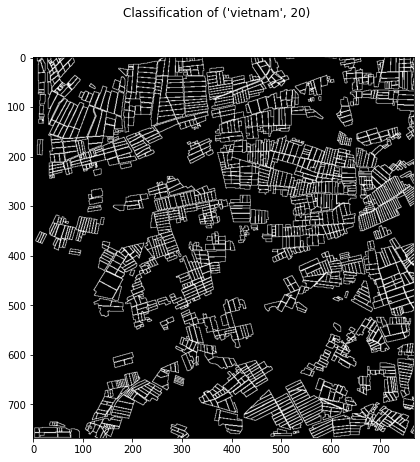

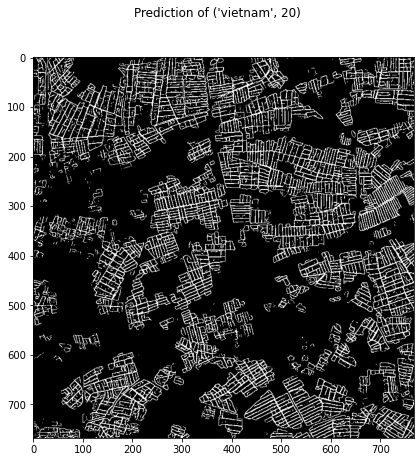

('vietnam', 20)


In [15]:
# ################################################################
# Evaluation of the test data
#
# In this step, the previously created test data set is feeded to
# the network. The network responds with a prediciton of field
# boundaries. The resulting data will be used to assess the
# accuracy of the network.
# ################################################################

predictions = dict()

for k in x_dict.keys():
    x_test = x_dict[k]
    y_test = y_dict[k]

    (_, _, f_weights, _) = get_file_names(NETWORK_UUID, NETWORK_NAME)

    result = evaluate_predictions(
        x_test,
        NUMBER_CLASSES,
        f_weights,
        OPTIMIZER,
        model_builder,
    )

    predictions[k] = result

    label = np.reshape(y_test, result.shape)

    print_map(label, f"Classification of {k}")
    print_map(result, f"Prediction of {k}")

In [17]:
# ################################################################
# Accuracy
# ################################################################

import pandas
from IPython.display import display

def get_binary_confusion_matrix(pred, exp):
    """Compute the confusion matrix.

    A confusion matrix is a matrix of the size n x n, where n is the number of
    different labels. In this case, the number of different labels is 2, thus we
    only cover the confusion matrix of a binary classification.

    The matrix can look something as in the example below:

            expected    | other          | field boundaries
    predicted           |                |
    --------------------|----------------|-----------------
    other               | true negative  | false negative
    field-boundaries    | false positive | true positive

    However, this function does not return a matrix, but only the corresponding
    sum of different values. The tuple returns values in this specific order:
        * true positive
        * false positive
        * false negative
        * true negative

    :param pred: ndarray with the predicted classes
    :param exp: preclassified data of the input images
    :return: A tuple of values that represent the confusion matrix
    """
    if exp.size != pred.size:
        raise ValueError("Invalid sizes of prediction and label input")

    exp = np.where(exp[:, :] == 2, True, False)
    pred = np.where(pred[:, :] == 2, True, False)

    tp, fp, fn, tn = 0, 0, 0, 0
    tp = np.sum(np.logical_and(exp, pred))
    fp = np.sum(np.logical_and(np.logical_not(exp), pred))
    fn = np.sum(np.logical_and(exp, np.logical_not(pred)))
    tn = np.sum(np.logical_and(np.logical_not(exp), np.logical_not(pred)))

    return (tp, fp, fn, tn)

"""
Confusion Matrix: flevoland 79
================================

	Actual Other 	Actual Field Boundary
Prediction Other 	619184 (96.748%) 	10495 (1.64%)
Prediction Field Boundary 	4758 (0.743%) 	5563 (0.869%)
"""



def print_binary_confusion_matrix(title, tp, fp, fn, tn):
    """Prints a nice little table of the confusion matrix

    :param title: The title of the confusion matrix
    :param tp: number of true positives
    :param fp: number of false positives
    :param fn: number of false negatives
    :param tn: number of true negatives
    """
    cm = [tp, fp, fn, tn]
    total = sum(cm)
    # percentages
    #(ptp, pfp, pfn, ptn) = tuple([int(100 * cm[i]) for i in range(len(cm))])
    (ptp, pfp, pfn, ptn)= tuple([100 * cm[i] / total for i in range(len(cm))])

    header_row = ["Actual Other", "Actual Field Boundary", "Sum"]
    header_col = ["Prediction Other", "Prediction Field Boundary", "Sum"]

    data = [
        [f"{tn} ({round(ptn, 3)}%)", f"{fn} ({round(pfn, 3)}%)", tn + fn],
        [f"{fp} ({round(pfp, 3)}%)", f"{tp} ({round(ptp, 3)}%)", fp + tp],
        [tn + fp, fn + tp, ""]
    ]

    df = pandas.DataFrame(data, header_col, header_row)
    print(f"Confusion Matrix: {title}")
    print("=" * 32)
    display(df)
    print("\n" * 3)


def print_scores(title, tp, fp, fn, tn):
    """Calculates and prints the typical precision scores of a machine learning
    algorithm.

    :param title: Title to be printed
    :param tp: number of true positives
    :param fp: number of false positives
    :param fn: number of false negatives
    :param tn: number of true negatives
    """
    total = sum([tp, fp, fn, tn])
    # Accuracy
    # How many pixels are classified correctly?
    accuracy = (tp + tn) / total

    # Precision / Specification
    # How accurate can the network determine field boundaries?
    precision = tp / (tp + fp)

    # Recall / Sensitivity
    # How many boundaries did we detect out of all actual field boundary pixels?
    recall = tp / (tp + fn)

    # F1 score
    # harmonic mean of recall & precision
    f1 = ( 2 * ( precision * recall ) ) / ( precision + recall )
    #f1 = 2 * ( ( precision * recall ) / (precision + recall) )


    accuracy *= 100
    precision *= 100
    recall *= 100
    f1 *= 100

    print(f"Accuracy Assessment: {title}")
    print("=" * 32)
    print("{:<32} {:<10} %".format("Overall Accuracy", round(accuracy, 3)))
    print("{:<32} {:<10} %".format("Precision", round(precision, 3)))
    print("{:<32} {:<10} %".format("Recall", round(recall, 3)))
    print("{:<32} {:<10} %".format("F1 Score", round(f1, 3)))
    print("\n" * 3)


def run_accuracy_assessment():
    """Simply performs an accuracy assessment based on the entire test data set
    and the results of the evaluation.
    """
    #        tp fp fn tn
    total = [0, 0, 0, 0]

    for k, p in predictions.items():
        # k = key, l = label, p = prediction
        l = np.reshape(y_dict[k], p.shape)
        cm = get_binary_confusion_matrix(p, l)
        (tp, fp, fn, tn) = cm
        print(cm)

        # Cumulate values
        for i in range(len(total)):
            total[i] += cm[i]

        # Print confusion matrix
        print_binary_confusion_matrix(f"{k[0]} {k[1]}", tp, fp, fn, tn)
        print_scores(f"{k[0]} {k[1]}", tp, fp, fn, tn)

    (tp, fp, fn, tn) = tuple(total)
    print_binary_confusion_matrix("Cumulated", tp, fp, fn, tn)
    print_scores("Cumulated", tp, fp, fn, tn)


run_accuracy_assessment()



(58449, 42904, 28545, 459926)
Confusion Matrix: vietnam 20


,Actual Other,Actual Field Boundary,Sum
Prediction Other,459926 (77.977%),28545 (4.84%),488471
Prediction Field Boundary,42904 (7.274%),58449 (9.91%),101353
Sum,502830,86994,






Accuracy Assessment: vietnam 20
Overall Accuracy                 87.886     %
Precision                        57.669     %
Recall                           67.187     %
F1 Score                         62.065     %




Confusion Matrix: Cumulated


,Actual Other,Actual Field Boundary,Sum
Prediction Other,459926 (77.977%),28545 (4.84%),488471
Prediction Field Boundary,42904 (7.274%),58449 (9.91%),101353
Sum,502830,86994,






Accuracy Assessment: Cumulated
Overall Accuracy                 87.886     %
Precision                        57.669     %
Recall                           67.187     %
F1 Score                         62.065     %




